# Immporting all the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import fashion_mnist

# Loading the data into the program

In [2]:
(train_data, train_label), (test_data, test_label) = fashion_mnist.load_data()
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Writing all the visualisation functions

In [4]:
def plot_decision_boundary(model, X, y):
    """
    PLots the decision boundary created by a model predicting on X.
    This function was inspired my two resources:
    1. https://cs231n.github.io/neural-networks-case-study/
    2. https://github.com/GokuMohandas/Made-With-ML
    """

    # Define the axis boundaries of the plot and create a meshgid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))
    
    #Create X values
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2d arrays together

    # Make predictions
    y_pred = model.predict(x_in)

    # Check for multi-class
    if len(y_pred[0]) > 1:
        print("Doing multiclass classification")
        # We have to reshape our prediction to get them ready for plotting
        y_pred = np.argmax(y_pred, axis= 1).reshape(xx.shape)
    else:
        print("doing binary classification")
        y_pred = np.round(y_pred).reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap= plt.cm.RdYlBu, alpha= 0.8)
    plt.scatter(X[:, 0], X[:, 1], c= y, s= 40, cmap= plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes= False, figsize= (10, 10), text_size= 15):
    '''
    Try it out by yourself by using y_true and y_pred as the parameters
    '''
    #Xreate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis= 1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Let's pretify it
    fig, ax = plt.subplots(figsize= figsize)

    cax = ax.matshow(cm, cmap= plt.cm.Blues)
    fig.colorbar(cax)

    #Create classes

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    #Label the axes
    ax.set(title= "Comnfusion Matrix",
        xlabel= "Predicted Label",
        ylabel= "True Label",
        xticks= np.arange(n_classes),
        yticks= np.arange(n_classes),
        xticklabels= labels,
        yticklabels= labels) 

    # Set axis labels to the bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    #Adjust label size
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)

    threshold = (cm.max() + cm.min()) / 2

    #Plot the tect on each cell
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                horizontalalignment= "center", 
                color= "white" if cm[i, j] > threshold else "black",
                size= text_size)


In [6]:
# Plotting random images from the dataset to analyse
def plot_random_images():
    plt.figure(figsize= (10, 7))

    rand_idx = [random.randrange(0, train_data.shape[0]) for _ in range(6)]
    for i in range(6):
        ax = plt.subplot(2, 3, 1 + i)
        plt.imshow(train_data[rand_idx[i]], cmap= plt.cm.binary)
        plt.title(class_names[train_label[rand_idx[i]]])
        plt.axis(False)
        

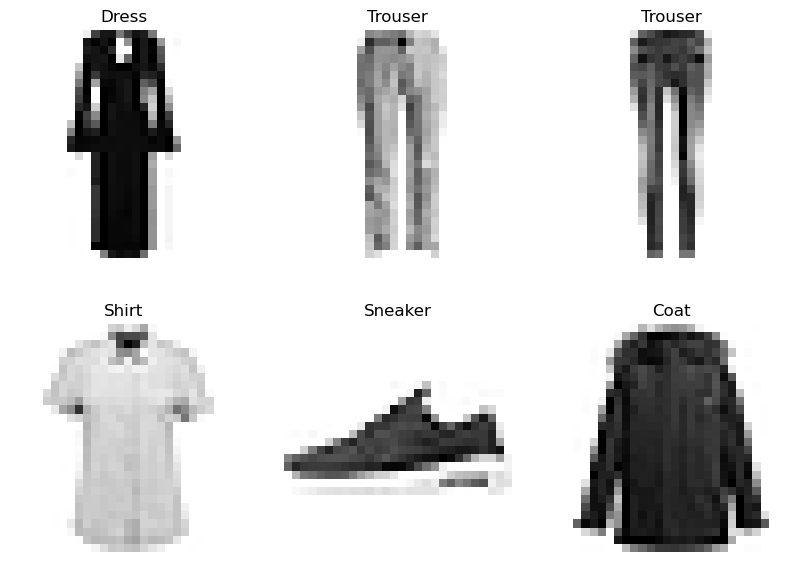

In [7]:
plot_random_images()

# Start developing models

Before proceeding towards models, we have seen before that normalisation is necessary for this dataset and many more steps that has been successful can be done from the start itself so that we can avoid those steps.

Steps to perform:
* Normalise the data
* Nullify the learning rate and start model from initial mode
* Elu, tanh activation functions have been very useful and let's find more such activation functions
* We are going to set the training epoch to 50 with verbose= 0 so that we can directly monitor the data visualisation.

In [8]:
train_data_norm = train_data / 255.0
test_data_norm = test_data / 255.0

In [9]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (28, 28)),
    tf.keras.layers.Dense(5, activation= 'elu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

model_1.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.SGD(),
                metrics= ['accuracy'])

history_1 = model_1.fit(train_data_norm, train_label,
            epochs= 50,
            validation_data= (test_data_norm, test_label),
            verbose= 0)

2024-02-05 11:08:38.214056: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
model_1.evaluate(test_data_norm, test_label)

313/313 [==============================] - 0s 292us/step - loss: 0.4954 - accuracy: 0.8305


[0.4953867197036743, 0.8305000066757202]

313/313 [==============================] - 0s 244us/step


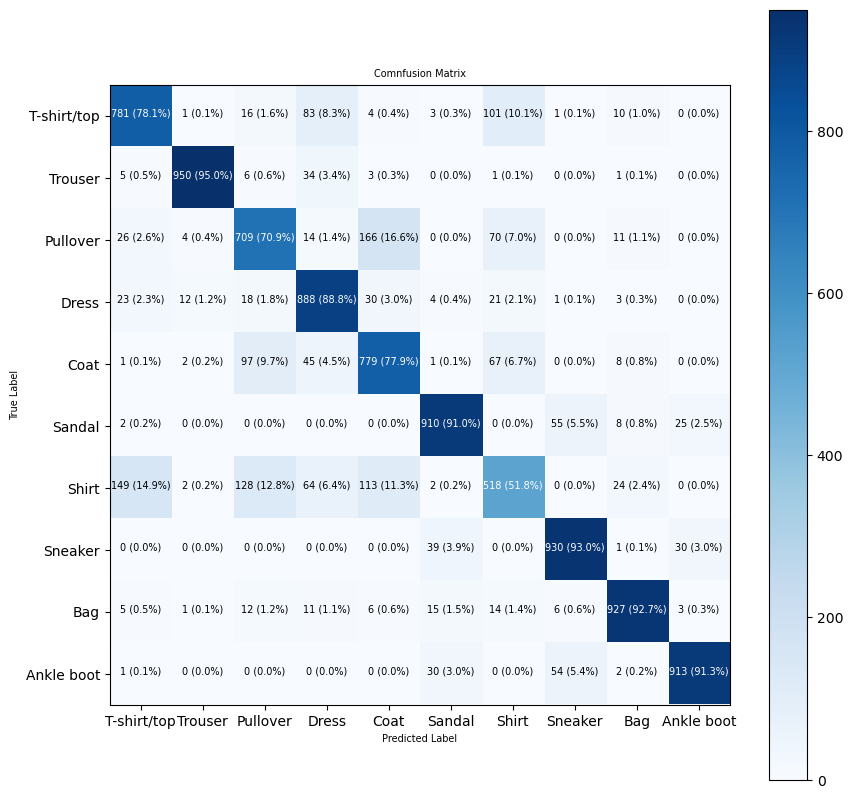

In [11]:
plot_confusion_matrix(y_true= test_label,
                      y_pred= tf.argmax(model_1.predict(test_data_norm), axis= 1),
                      text_size= 7,
                      classes= class_names)

In [12]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (28, 28)),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(5, activation= 'elu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

model_2.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.SGD(),
                metrics= ['accuracy'])

history_2 = model_2.fit(train_data_norm, train_label,
            epochs= 50,
            validation_data= (test_data_norm, test_label),
            verbose= 0)

In [13]:
model_2.evaluate(test_data_norm, test_label)

313/313 [==============================] - 0s 276us/step - loss: 0.4981 - accuracy: 0.8297


[0.49808818101882935, 0.8296999931335449]

313/313 [==============================] - 0s 260us/step


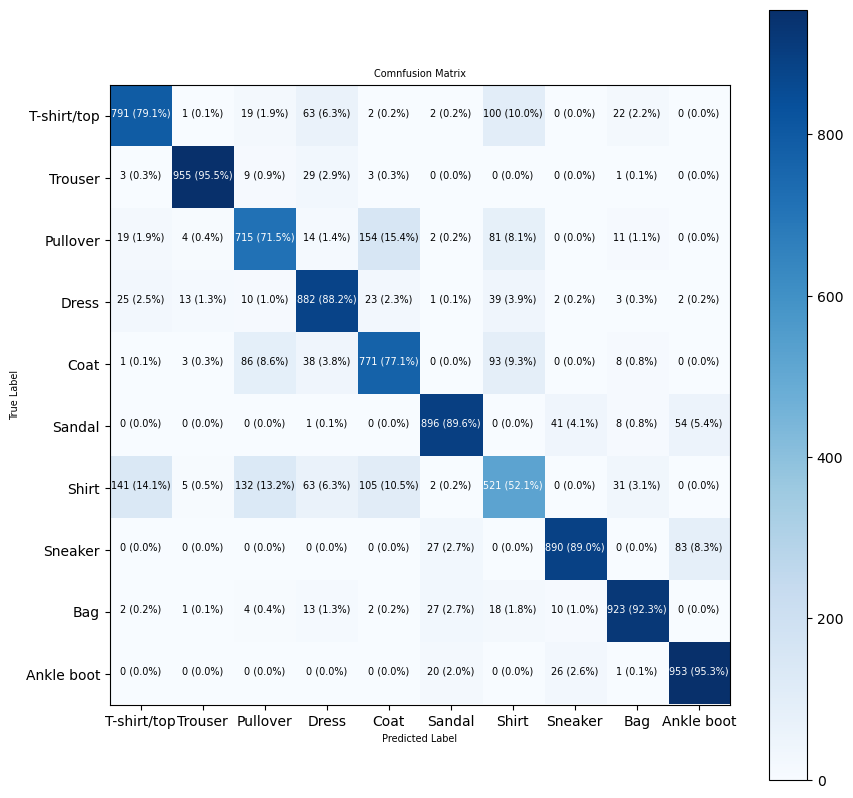

In [14]:
plot_confusion_matrix(test_label,
                      tf.argmax(model_2.predict(test_data_norm),axis= 1),
                      text_size= 7,
                      classes= class_names)

In [15]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (28, 28)),
    tf.keras.layers.Dense(5, activation= 'elu'),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

model_3.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.SGD(),
                metrics= ['accuracy'])

history_3 = model_3.fit(train_data_norm, train_label,
            epochs= 50,
            validation_data= (test_data_norm, test_label),
            verbose= 0)

In [16]:
model_3.evaluate(test_data_norm, test_label)

313/313 [==============================] - 0s 251us/step - loss: 0.4991 - accuracy: 0.8277


[0.4991370141506195, 0.8277000188827515]

313/313 [==============================] - 0s 208us/step


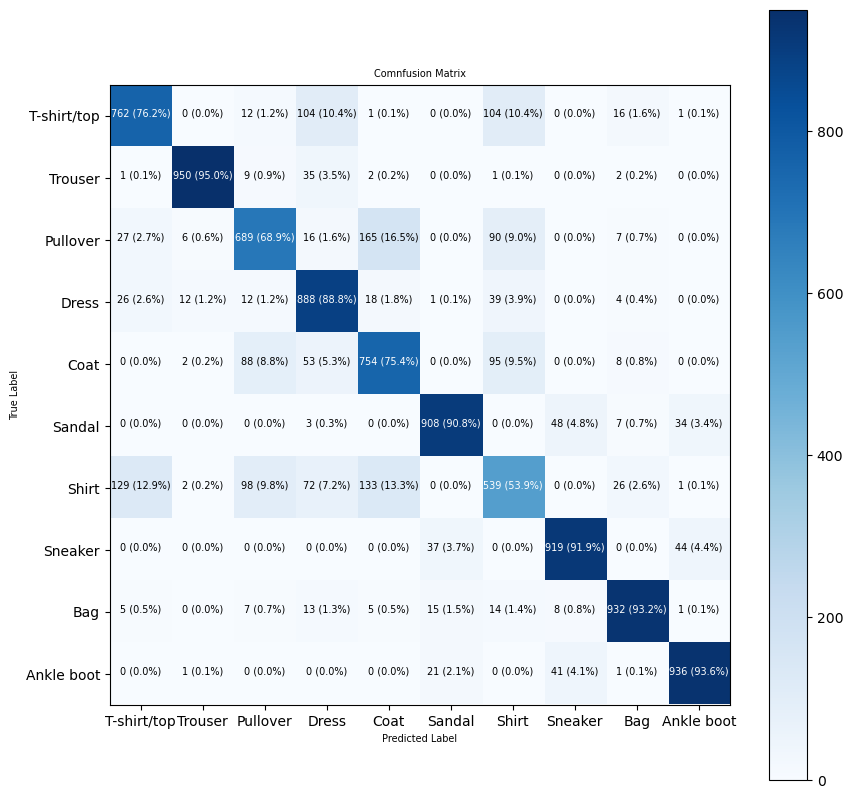

In [17]:
plot_confusion_matrix(test_label,
                      tf.argmax(model_3.predict(test_data_norm), axis= 1),
                      text_size= 7,
                      classes= class_names)

In [18]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (28, 28)),
    tf.keras.layers.Dense(5, activation= 'elu'),
    tf.keras.layers.Dense(5, activation= 'tanh'),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

model_4.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.SGD(),
                metrics= ['accuracy'])

history_4 = model_4.fit(train_data_norm, train_label,
            epochs= 50,
            validation_data= (test_data_norm, test_label),
            verbose= 0)

In [19]:
model_4.evaluate(test_data_norm, test_label)

313/313 [==============================] - 0s 254us/step - loss: 0.4880 - accuracy: 0.8344


[0.48803260922431946, 0.8343999981880188]

313/313 [==============================] - 0s 213us/step


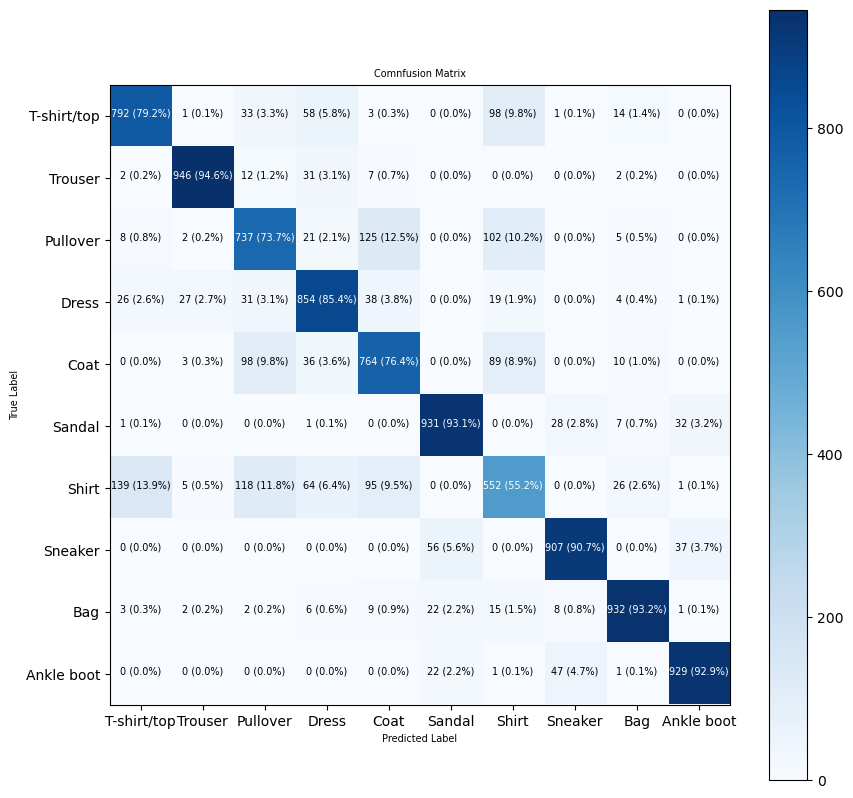

In [20]:
plot_confusion_matrix(test_label,
                      tf.argmax(model_4.predict(test_data_norm), axis= 1),
                      text_size= 7,
                      classes= class_names)

In [21]:
tf.random.set_seed(42)

model_5 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (28, 28)),
    tf.keras.layers.Dense(5, activation= 'elu'),
    # tf.keras.layers.Dense(5, activation= 'tanh'),
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

model_5.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.SGD(),
                metrics= ['accuracy'])

history_5 = model_5.fit(train_data_norm, train_label,
            epochs= 50,
            validation_data= (test_data_norm, test_label),
            verbose= 0)

In [22]:
model_5.evaluate(test_data_norm, test_label)

313/313 [==============================] - 0s 252us/step - loss: 0.4685 - accuracy: 0.8346


[0.4685435891151428, 0.8345999717712402]

313/313 [==============================] - 0s 212us/step


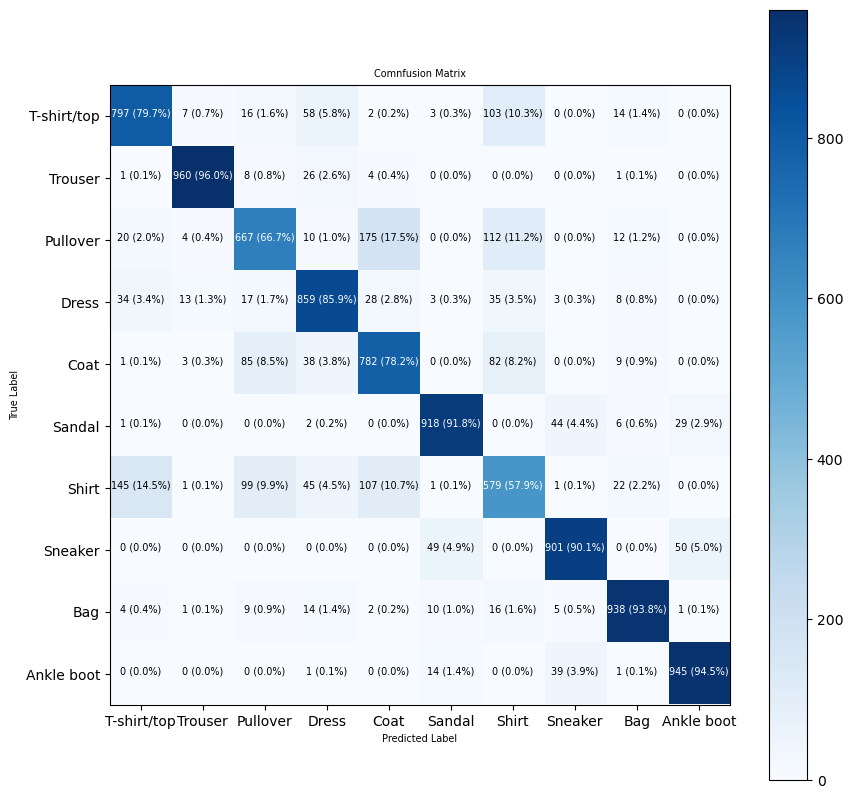

In [23]:
plot_confusion_matrix(test_label,
                      tf.argmax(model_5.predict(test_data_norm), axis= 1),
                      text_size= 7,
                      classes= class_names)

In [27]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (28, 28)),
    tf.keras.layers.Dense(50, activation= 'elu'),
    tf.keras.layers.Dense(50, activation= 'tanh'),
    # tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

model_6.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.SGD(),
                metrics= ['accuracy'])

history_6 = model_6.fit(train_data_norm, train_label,
            epochs= 50,
            validation_data= (test_data_norm, test_label),
            verbose= 0)

In [28]:
model_6.evaluate(test_data_norm, test_label)

  1/313 [..............................] - ETA: 3s - loss: 0.6119 - accuracy: 0.8750

313/313 [==============================] - 0s 367us/step - loss: 0.3377 - accuracy: 0.8840


[0.3377229869365692, 0.8840000033378601]

313/313 [==============================] - 0s 287us/step


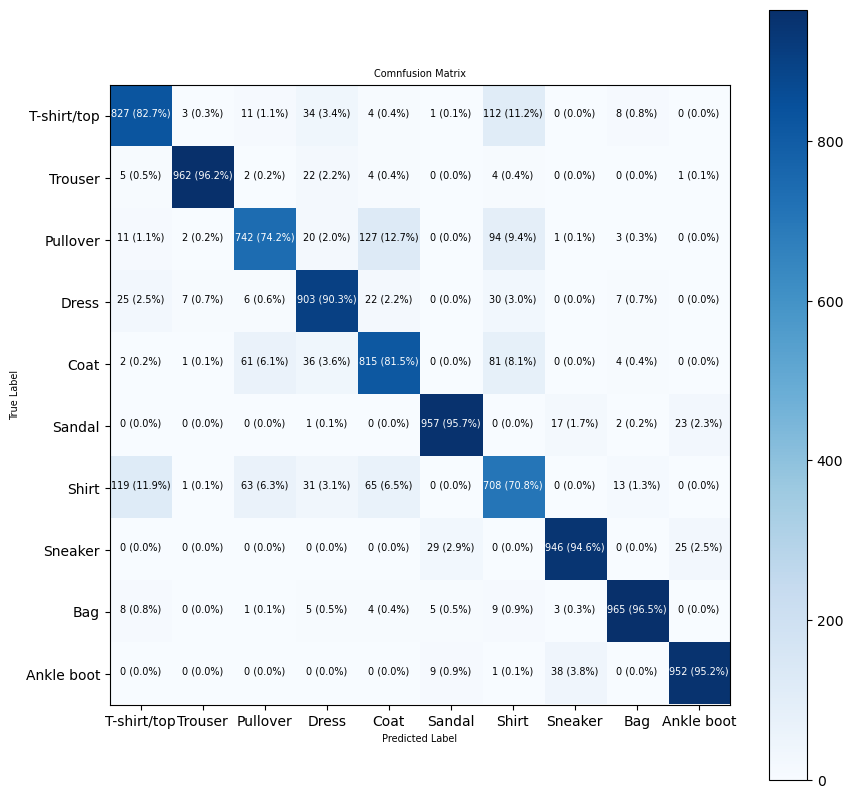

In [26]:
plot_confusion_matrix(test_label,
                      tf.argmax(model_6.predict(test_data_norm), axis= 1),
                      text_size= 7,
                      classes= class_names)

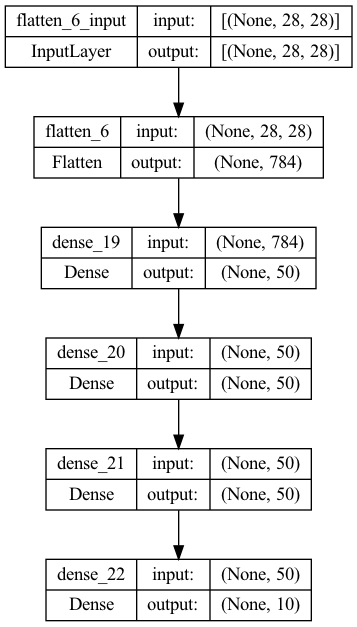

In [40]:
plot_model(model_6, show_shapes= True)

In [29]:
tf.keras.models.save_model(model_6, "Fashion_MNIST_Classification.h5")

In [99]:
def plot_image():
    rand_idx = random.randrange(0, test_data.shape[0])

    probability = model_6.predict(tf.reshape(test_data_norm[rand_idx], shape= (1, 28, 28)))

    if tf.argmax(probability, axis= 1) == test_label[rand_idx]:
        color = "green"
    else:
        color = "red"

    plt.figure(figsize= (10, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(test_data[rand_idx])
    plt.axis(False)
    plt.title(f"Predicted: {class_names[tf.argmax(probability, axis= 1)[0].numpy()]} {(tf.reduce_max(probability) * 100):.2f} (True Label: {class_names[test_label[rand_idx]]})", 
               color= color)
    
    plt.subplot(1, 2, 2)

    plt.bar(class_names, probability.squeeze())
    plt.xticks(fontsize= 7)
    plt.tight_layout()

1/1 [==============================] - 0s 13ms/step


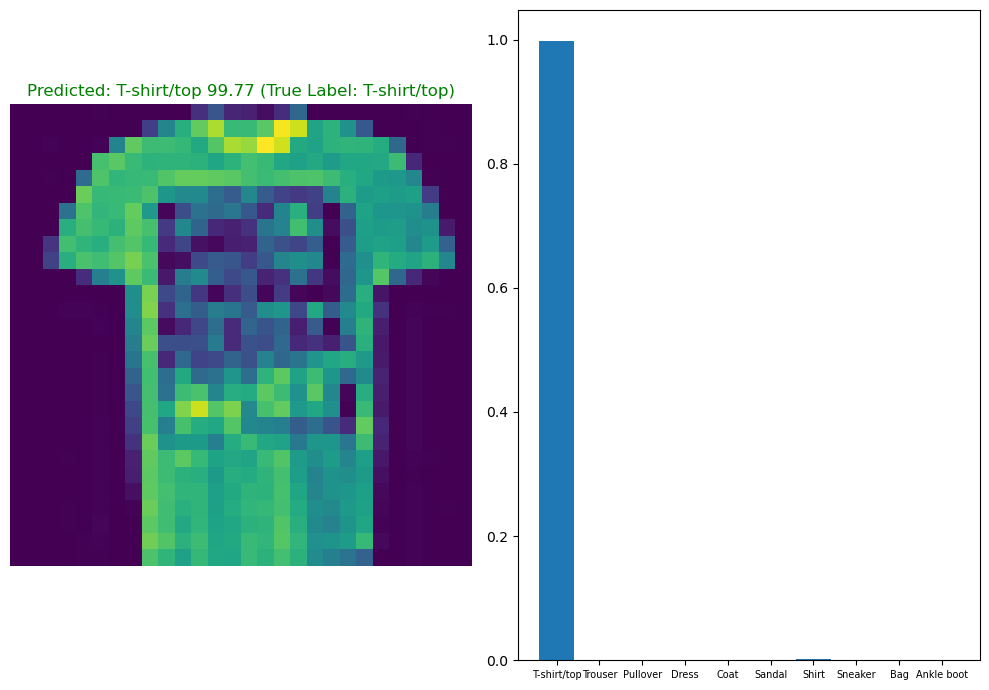

In [101]:
plot_image()

In [76]:
model_6.predict(tf.reshape(test_data[0], shape= (1, 28, 28))).squeeze().shape

1/1 [==============================] - 0s 10ms/step


(10,)

1/1 [==============================] - 0s 11ms/step


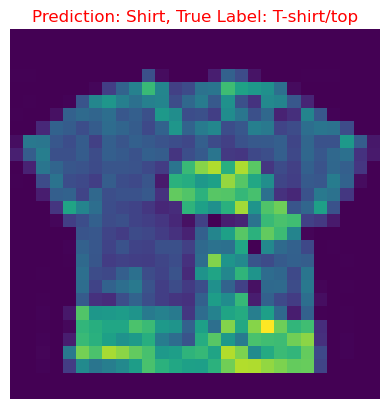

In [128]:
def selecting_outfit(cloth):    
    index_list = []
    i = 0
    test_label_bool = test_label == class_names.index(cloth)
    for i in range(test_label.shape[0]):
        if test_label_bool[i]:
            index_list.append(i)

    rand_idx = random.choice(index_list)

    if tf.argmax(model_6.predict(test_data_norm[rand_idx].reshape((1, 28, 28))), axis= 1)[0] == test_label[rand_idx]:
        color= "green"
    else:
        color= "red"

    plt.imshow(test_data[rand_idx])
    plt.axis(False)
    plt.title(f"Prediction: {class_names[tf.argmax(model_6.predict(test_data_norm[rand_idx].reshape((1, 28, 28))), axis= 1)[0]]}, True Label: {class_names[test_label[rand_idx]]}", color= color)

selecting_outfit('T-shirt/top')

1/1 [==============================] - 0s 10ms/step


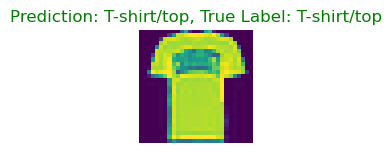

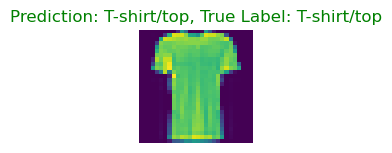

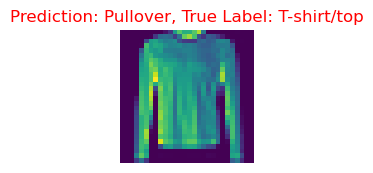

In [140]:
for _ in range(3):
    plt.figure(figsize= (5, 5))
    plt.subplot(3, 1, _ + 1)
    selecting_outfit("T-shirt/top")

plt.tight_layout()

1/1 [==============================] - 0s 10ms/step


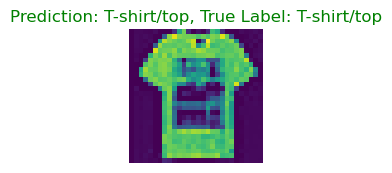

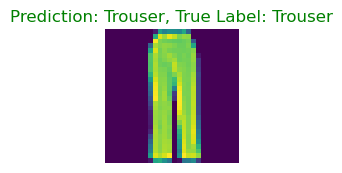

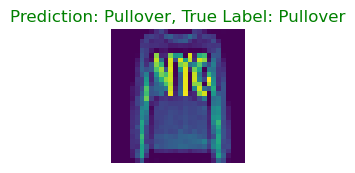

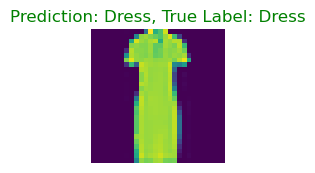

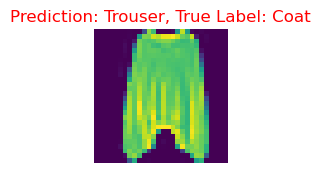

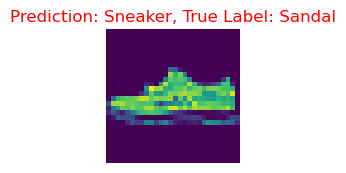

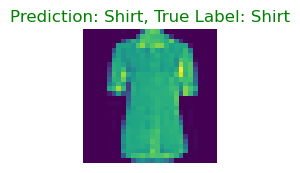

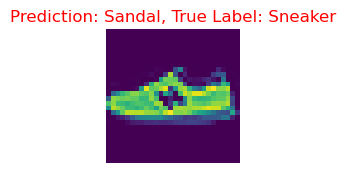

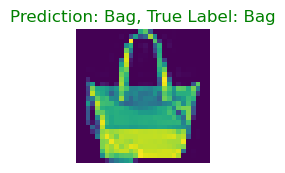

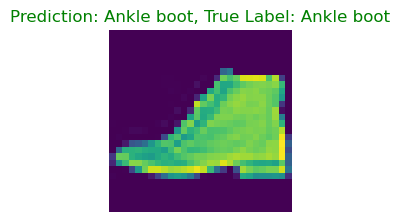

In [132]:
for i, cloth in enumerate(class_names):
    plt.figure(figsize= (10, 7))
    plt.subplot(2, 5, i + 1)
    selecting_outfit(cloth= cloth)

plt.tight_layout()